<a href="https://colab.research.google.com/github/viriditass/TIL/blob/main/Attention_Is_All_You_Need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer (Attention Is All You Need) 구현하기
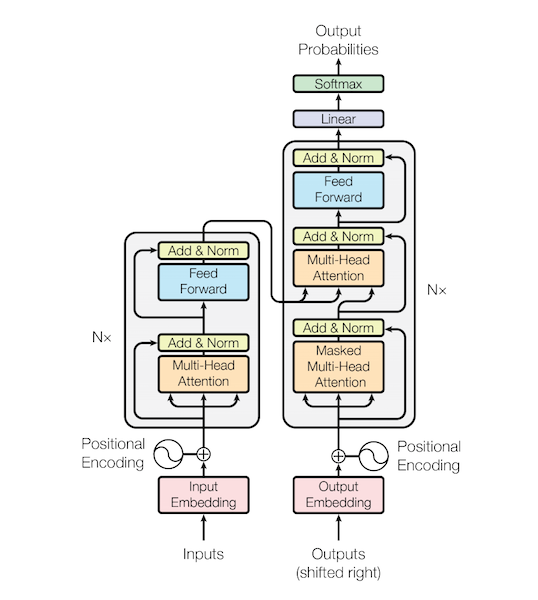

Transformer는 자연어처리에서 가장 중요한 논문이라고 생각이 됩니다. 

이유는 2019년 12월 현재 각종 Benchmark 에서 가장 좋은 성능을 내고 있는 모델들이 Transformer 기반의 Pretrained 모델이기 때문 입니다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/My Drive/Kowiki"

Mounted at /content/drive


In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.7MB/s 


In [3]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
for i in os.listdir(data_dir):
  print(i)

kowiki.model
kowiki.vocab
kowiki.csv.gz
ratings_test.json
ratings_test.txt
ratings_train.json
ratings_train.txt


## 1. Vocab
이미 만들어 놓은 vocab을 이용해 텍스트를 입력 tensor로 변경합니다.

In [5]:
# vocab loading
vocab_file = f"{data_dir}/kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# 입력 texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# text를 tensor로 변환
inputs = []
for line in lines:
  pieces = vocab.encode_as_pieces(line)
  ids = vocab.encode_as_ids(line)
  inputs.append(torch.tensor(ids))
  print(pieces)

# 입력 길이가 다르므로 입력 최대 길이에 맟춰 padding(0)을 추가 해 줌
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# 값
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])


## 2. Embedding
Transformer의 Embedding은 'Input Embedding'과 'Postion Embedding' 두 가지를 합해서 사용 합니다.

- Input Embedding

embedding은 입력 토큰을 vector 형태로 변환합니다.

1. inputs에 대한 embedding 값 input_embs를 구합니다.

In [6]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding 객체

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


위와 같이 inputs(2,8)에 대한 embedding값 input_embs(2,8,128) shape를 갖습니다.

- Position Embedding

Position encoding값을 구하기 위한 함수는 아래와 같습니다.
1. 각 position별도 angle 값을 구합니다.
2. 주어진 angle 중 짝수 index의 값에 대한 sin값을 구합니다.
3. 구해진 angle 중 홀수 index의 값에 대한 cos값을 구합니다.

In [7]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

아래와 같이 position encoding값을 구하면 됩니다.

(64, 128)


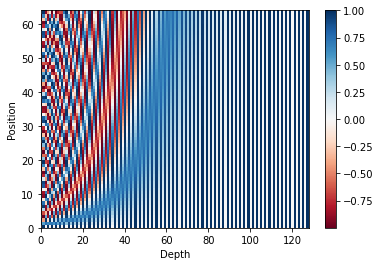

In [8]:
n_seq = 64
pos_encoding = get_sinusoid_encoding_table(n_seq, d_hidn)

print (pos_encoding.shape) # 크기 출력
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

위에서 구한 결괴를 그래프로 출력하면 아래와 같이 각 position 별로 다른 값을 갖는 것을 확인 할 수 있습니다.

아래 절차로 position embedding 값을 구합니다.

1. 위에서 구해진 position encoding 값을 이용해 position embedding을 생성합니다. 학습되는 값이 아니므로 freeze옵션을 True로 설정합니다.
2. 입력 inputs과 동일한 크기를 갖는 positions값을 구합니다.
3. input값 중 pad(0)값을 찾습니다.
4. positions값 중 pad부분은 0으로 변경합니다.
5. positions값에 해당하는 embedding값을 구합니다.

In [9]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(inputs)
print(positions)
print(pos_embs.size())

tensor([[3091, 3604,  206, 3958, 3760, 3590,    0,    0],
        [ 212, 3605,   53, 3832, 3596, 3682, 3760, 3590]])
tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


위의 출력 결과를 통해 inputs의 pad(0) 위치에 positions의 값도 pad(0)으로 변경되어 있음을 알 수 있습니다.

pos_embs(3,13,128)은 input_embs(3,13,128)과 shape이 동일합니다.

In [10]:
input_sums = input_embs + pos_embs

위에서 구한 inputs_embs과 pos_embs를 더하면 transformer에 입력할 input이 됩니다.

## 3. Scaled Dot Product Attention
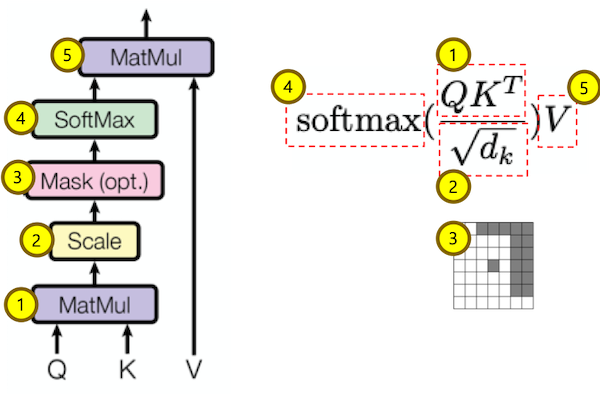

**입력값**

입력값은 Q(query), K(key), V(value) 그리고 attention mask로 구성 되어 있습니다.

입력값 중 K, V는 같은 값 이어야 합니다.
Q, K, V가 모두 동일한 경우는 self attention이라 합니다.

In [11]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0])

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


attn_mask의 값은 pad(0) 부분만 True입니다.

### MatMul Q, K-transpose

위 그림의 수식 중 1번 Q * K-transpose를 하는 코드입니다.

In [12]:
scores = torch.matmul(Q, K.transpose(-1, -2))
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[201.4987,  54.7218,  72.7855,  65.8942,  43.1760,  75.4187,  79.9311,
          79.9311],
        [ 54.7218, 188.3979,  72.2041,  59.5499,  53.9852,  76.1097,  65.8101,
          65.8101],
        [ 72.7855,  72.2041, 174.1725,  72.6457,  57.9385,  66.7278,  63.1675,
          63.1675],
        [ 65.8942,  59.5499,  72.6457, 173.9665,  53.4445,  50.3736,  33.6999,
          33.6999],
        [ 43.1760,  53.9852,  57.9385,  53.4445, 176.6915,  47.9280,  50.1703,
          50.1703],
        [ 75.4187,  76.1097,  66.7278,  50.3736,  47.9280, 183.4108,  65.8725,
          65.8725],
        [ 79.9311,  65.8101,  63.1675,  33.6999,  50.1703,  65.8725, 183.2608,
         183.2608],
        [ 79.9311,  65.8101,  63.1675,  33.6999,  50.1703,  65.8725, 183.2608,
         183.2608]], grad_fn=<SelectBackward>)


각 단어상호간에 가중치를 표현하는 테이블이 생성 되었습니다.

**Scale**

위 그림의 수식 중 2번 k-dimension에 루트를 취한 값으로 나누는 코드입니다.

In [13]:
d_head = 64
scores = scores.mul_(1/d_head**0.5)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[25.1873,  6.8402,  9.0982,  8.2368,  5.3970,  9.4273,  9.9914,  9.9914],
        [ 6.8402, 23.5497,  9.0255,  7.4437,  6.7481,  9.5137,  8.2263,  8.2263],
        [ 9.0982,  9.0255, 21.7716,  9.0807,  7.2423,  8.3410,  7.8959,  7.8959],
        [ 8.2368,  7.4437,  9.0807, 21.7458,  6.6806,  6.2967,  4.2125,  4.2125],
        [ 5.3970,  6.7481,  7.2423,  6.6806, 22.0864,  5.9910,  6.2713,  6.2713],
        [ 9.4273,  9.5137,  8.3410,  6.2967,  5.9910, 22.9264,  8.2341,  8.2341],
        [ 9.9914,  8.2263,  7.8959,  4.2125,  6.2713,  8.2341, 22.9076, 22.9076],
        [ 9.9914,  8.2263,  7.8959,  4.2125,  6.2713,  8.2341, 22.9076, 22.9076]],
       grad_fn=<SelectBackward>)


위 값에 비해서 가중치 편차가 줄어든 것을 확인 할 수 있습니다.

**Mask (Opt.)**

위 그림 수식 중 3번 mask를 하는 코드입니다.

In [14]:
scores.masked_fill_(attn_mask, -1e9)
print(scores.size())
print(scores[0])

torch.Size([2, 8, 8])
tensor([[ 2.5187e+01,  6.8402e+00,  9.0982e+00,  8.2368e+00,  5.3970e+00,
          9.4273e+00, -1.0000e+09, -1.0000e+09],
        [ 6.8402e+00,  2.3550e+01,  9.0255e+00,  7.4437e+00,  6.7481e+00,
          9.5137e+00, -1.0000e+09, -1.0000e+09],
        [ 9.0982e+00,  9.0255e+00,  2.1772e+01,  9.0807e+00,  7.2423e+00,
          8.3410e+00, -1.0000e+09, -1.0000e+09],
        [ 8.2368e+00,  7.4437e+00,  9.0807e+00,  2.1746e+01,  6.6806e+00,
          6.2967e+00, -1.0000e+09, -1.0000e+09],
        [ 5.3970e+00,  6.7481e+00,  7.2423e+00,  6.6806e+00,  2.2086e+01,
          5.9910e+00, -1.0000e+09, -1.0000e+09],
        [ 9.4273e+00,  9.5137e+00,  8.3410e+00,  6.2967e+00,  5.9910e+00,
          2.2926e+01, -1.0000e+09, -1.0000e+09],
        [ 9.9914e+00,  8.2263e+00,  7.8959e+00,  4.2125e+00,  6.2713e+00,
          8.2341e+00, -1.0000e+09, -1.0000e+09],
        [ 9.9914e+00,  8.2263e+00,  7.8959e+00,  4.2125e+00,  6.2713e+00,
          8.2341e+00, -1.0000e+09, -1.0000e

mask를 한 부분이 -1e9로 매우 작은 값으로 변경된 것을 확인할 수 있습니다.

**Softmax**

위 그림 수식 중 4번 softmax를 하는 코드입니다.

In [15]:
attn_prob = nn.Softmax(dim=-1)(scores)
print(attn_prob.size())
print(attn_prob[0])

torch.Size([2, 8, 8])
tensor([[1.0000e+00, 1.0763e-08, 1.0294e-07, 4.3498e-08, 2.5419e-09, 1.4306e-07,
         0.0000e+00, 0.0000e+00],
        [5.5354e-08, 1.0000e+00, 4.9227e-07, 1.0122e-07, 5.0485e-08, 8.0210e-07,
         0.0000e+00, 0.0000e+00],
        [3.1334e-06, 2.9138e-06, 9.9999e-01, 3.0792e-06, 4.8980e-07, 1.4695e-06,
         0.0000e+00, 0.0000e+00],
        [1.3586e-06, 6.1473e-07, 3.1595e-06, 9.9999e-01, 2.8658e-07, 1.9522e-07,
         0.0000e+00, 0.0000e+00],
        [5.6476e-08, 2.1810e-07, 3.5750e-07, 2.0385e-07, 1.0000e+00, 1.0229e-07,
         0.0000e+00, 0.0000e+00],
        [1.3723e-06, 1.4961e-06, 4.6307e-07, 5.9956e-08, 4.4164e-08, 1.0000e+00,
         0.0000e+00, 0.0000e+00],
        [6.6934e-01, 1.1457e-01, 8.2339e-02, 2.0697e-03, 1.6219e-02, 1.1547e-01,
         0.0000e+00, 0.0000e+00],
        [6.6934e-01, 1.1457e-01, 8.2339e-02, 2.0697e-03, 1.6219e-02, 1.1547e-01,
         0.0000e+00, 0.0000e+00]], grad_fn=<SelectBackward>)


가중치가 확률로 변환 된 값을 볼 수 있습니다. mask를 한 부분이 모두 0이 되었습니다.

**MatMul attn_prov, V**

위 그림 수식 중 5번 attn_prov * V를 하는 코드입니다.

In [16]:
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


Q와 동일한 shape 값이 구해집니다. 이 값은 V값들이 attn_prov의 가중치를 이용해서 더해진 값 입니다.

**Class**

위 절차를 하나의 클래스 형태로 구성하면 아래와 같습니다.

In [17]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## 4. Multi-Head Attention
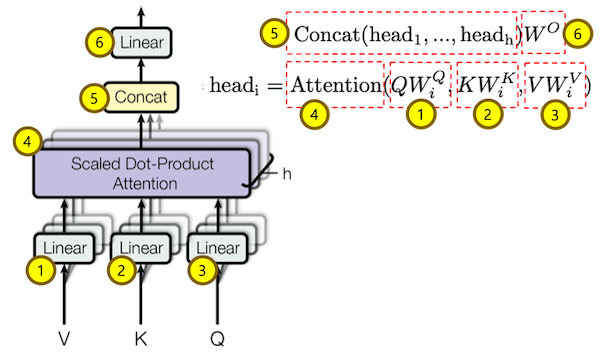

**입력값**

Q, K, V, attn_mask는 Scaled Dot Product Attention과 동일합니다.

head 개수는 2개, head의 dimension은 64입니다.

In [18]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

batch_size = Q.size(0)
n_head = 2

**Multi Head Q, K, V**

위 그림 수식 중 1번 Q를 여러개의 head로 나누는 과정입니다.

In [19]:
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_seq, n_head * d_head)
q_s = W_Q(Q)
print(q_s.size())

# (bs, n_seq, n_head, d_head)
q_s = q_s.view(batch_size, -1, n_head, d_head)
print(q_s.size())

# (bs, n_head, n_seq, d_head)
q_s = q_s.transpose(1,2)
print(q_s.size())

torch.Size([2, 8, 128])
torch.Size([2, 8, 2, 64])
torch.Size([2, 2, 8, 64])


Q값이 head단위로 나눠졌습니다.

위 과정을 한 줄로 표현하면 다음과 같습니다.

In [20]:
# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)

# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)

# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)

print(q_s.size(), k_s.size(), v_s.size())

torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64]) torch.Size([2, 2, 8, 64])


Q, K, V 모두 Multi Head로 나눠졌습니다.

Attention Mask를 Multi Head로 변경하는 코드는 다음과 같습니다.

In [21]:
print(attn_mask.size())
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1)
print(attn_mask.size())

torch.Size([2, 8, 8])
torch.Size([2, 2, 8, 8])


**Attention**

위 그림 수식 중 4번 Attention 과정입니다.

이전에 설명한 'Scaled Dot Product Attention'을 사용합니다.

In [22]:
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)
print(context.size())
print(attn_prob.size())

torch.Size([2, 2, 8, 64])
torch.Size([2, 2, 8, 8])


Multi Head에 대한 Attention이 구해졌습니다.

**Concat**

위 그림 수식 중 5번 Concat 과정입니다.

In [23]:
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)
print(context.size())

torch.Size([2, 8, 128])


Multi Head를 한개로 합쳤습니다.

**Linear**

위 그림 수식 중 6번 Linear 과정입니다.

In [24]:
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)
print(output.size())

torch.Size([2, 8, 128])


입력 Q와 동일한 shape를 가진 Multi Head Attention이 구해졌습니다.

**Class**

위 절차를 하나의 클래스 형태로 구성하면 아래와 같습니다.

In [25]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## 5. Masked Multi-Head Attention

Masked Multi-Head Attention은 Multi-Head Attention과 attention mask를 제외한 부분은 모두 동일합니다.

**입력값**

In [26]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_pad_mask[1])
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],


pad mask, decoder mask 그리고 이 둘을 합한 attention mask를 확인 할 수 있습니다.

**Multi-Head Attention**

Multi-Head Attention과 동일하므로 위에서 선언한 MultiHeadAttention 클래스를 바로 호출합니다.

In [27]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


## 6. FeeedForward
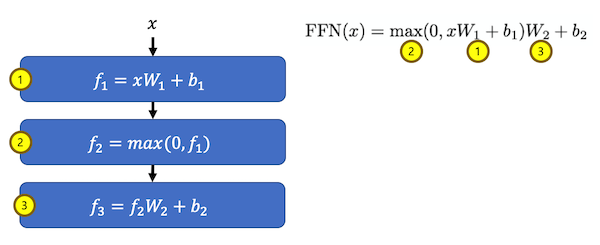

**f1 (Linear)**

위 그림 수식 중 1번 f1 (Linear) 과정입니다.

In [32]:
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn*4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print(ff_1.size())

torch.Size([2, 512, 8])


입력에 비해 hidden dimension이 4배 커진 것을 확인 할 수 있습니다.

**Activation (relut or gelu)**

위 그림 수식 중 2번 Activation (relu or gelu) 과정입니다.

논문이 발표 될 당시는 relu를 사용하도록 되어 있었지만 이후 gelu를 사용할 때 더 성능이 좋다는 것이 발견되었습니다.
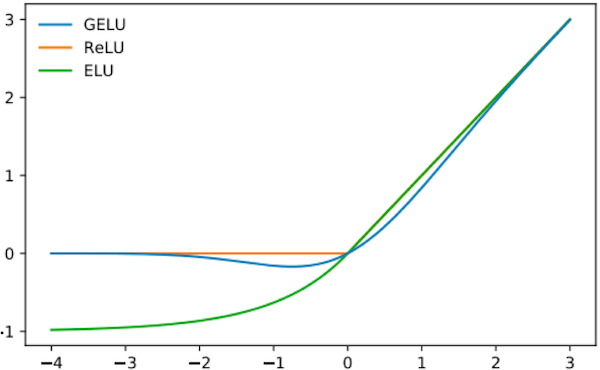

In [33]:
# active = F.relu
active = F.gelu
ff_2 = active(ff_1)

**f3 (Linear)**

위 그림 수식 중 3번 f3 (Linear) 과정입니다.

In [34]:
conv2 = nn.Conv1d(in_channels=d_hidn*4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print(ff_3.size())

torch.Size([2, 8, 128])


입력과 동일한 shape으로 변경된 결과를 확인 할 수 있습니다.

**Class**

위 절차를 하나의 클래스 형태로 구성하면 아래와 같습니다.

In [35]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

## Config

Transformer 모델에는 많은 설정이 필요합니다. 이 설정을 json 형태로 저장을 하고 이를 읽어서 처리하는 간단한 클래스입니다.

In [36]:
""" configuration json을 읽어들이는 class """
class Config(dict):
  __getattr__ = dict.__getitem__
  __setattr__ = dict.__setitem__

  @classmethod
  def load(cls, file):
    with open(file, 'r') as f:
      config = json.loads(f.read())
      return Config(config)

작은 리소스에서도 동작 가능하도록 여러 파라미터를 작게 설정했습니다. 가지고 게신 GPU에 여유가 있을시 파라미터를 키우면 더 좋은 결과를 확인 할 수 있습니다. 기본 파라미터는 아래와 같습니다.

In [37]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


## Common Class



Position Embedding의 초기 값을 구하는 함수는 위에 있는 def_get_sinusoid_ecoding_table를 참고하면 됩니다.

**Attention Pad Mask**

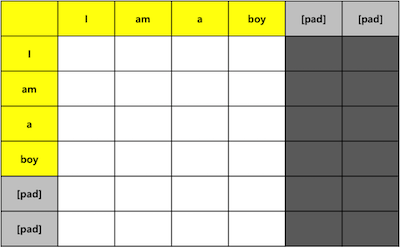

Attention을 구할 때 Padding 부분을 제외하기 위한 Mask를 구하는 함수입니다.

1. K의 값 중에 Pad인 부분을 True로 변경합니다. (나머지는 False)
2. 구해진 값의 크기를 Q-len, K-len 되도록 변경합니다.

In [38]:
""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()
  pad_attn_mask = seq_k.data.eq(i_pad)
  pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
  return pad_attn_mask

**Attention Decoder Mask**

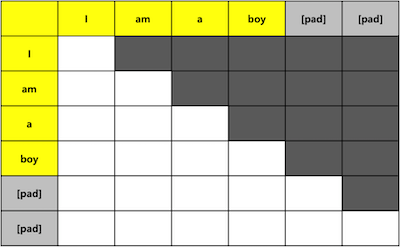

Decoder의 'Masked Multi Head Attention'에서 사용할 Mask를 구하는 함수입니다. 현재단어와 이전단어는 볼 수 있고 다음 단어는 볼 수 없도록 Masking합니다.

1. 모든 값이 1인 Q-len, K-len 테이블을 생성합니다.
2. 대각선을 기준으로 아래쪽을 0으로 만듭니다.

In [39]:
""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask

**Scaled Dot Product Attention**

코드는 위에 있는 class ScaledDotProductAttention을 참고하시면 됩니다.

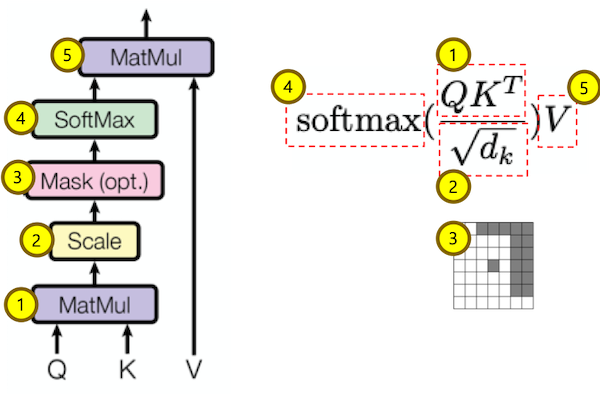

**Multi-Head Attention**

코드는 위에 있는 class MultiHeadAttention을 참고하시면 됩니다.

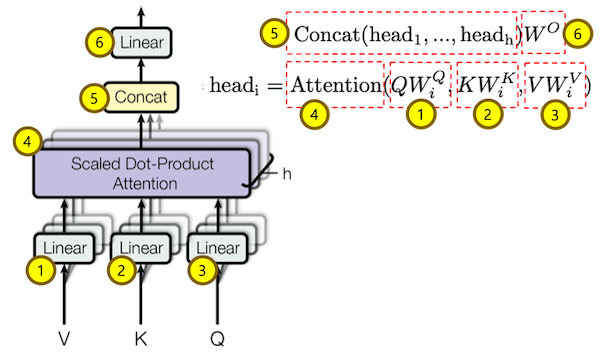

**FeeedForward**

코드는 위에 있는 class PoswiseFeedForwardNet을 참고하시면 됩니다.

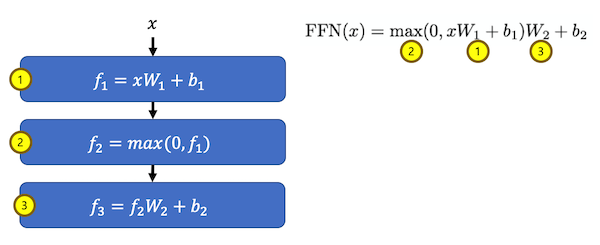

## Encoder

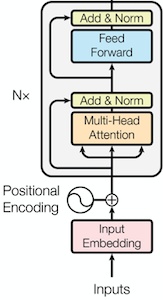

**Encoder Layer**

Encoder에서 루프를 돌며 처리 할 수 있도록 EncoderLayer를 정의하고 여러 개 만들어서 실행합니다.

1. Multi-Head Attention을 수행합니다. Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.
3. 2번의 결과를 입력으로 FeeedForward를 실행합니다.
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

In [40]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        att_outputs = self.layer_norm1(inputs + att_outputs)
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

**Encoder**

Encoder 클래스입니다.
1. 입력에 대한 Position 값을 구합니다.
2. Input Embedding과 Position Embedding을 구한 후 더합니다.
3. 입력에 대한 attention pad mask를 구합니다.
4. for 루프를 돌며 각 layer를 실행합니다. layer의 입력은 이전 layer의 출력값입니다.

In [41]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)

        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)

        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)

        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

## Decoder

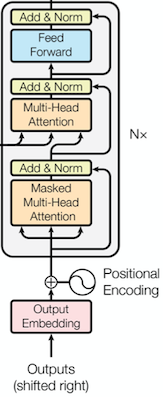

**Decoder Layer**

Decoder에서 루프를 돌며 처리 할 수 있도록 DecoderLayer를 정의하고 여러 개 만들어서 실행합니다.

1. Multi-Head Attention을 수행합니다. Q, K, V 모두 동일한 값을 사용하는 self-attention입니다.
2. 1번의 결과와 input(residual)을 더한 후 LayerNorm을 실행합니다.
3. Encoder-Decoder Multi-Head Attention을 수행합니다.

Q: 2번의 결과

K, V: Encoder 결과
4. 3번의 결과와 2번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.
5. 4번의 결과를 입력으로 FeeedForward를 실행합니다.
6. 5번의 결과와 4번의 결과(residual)을 더한 후 LayerNorm을 실행합니다.

In [42]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

**Decoder**

Decoder 클래스 입니다.

1. 입력에 대한 Position 값을 구합니다.
2. Input Embedding과 Position Embedding을 구한 후 더합니다.
3. 입력에 대한 attention pad mask를 구합니다.
4. 입력에 대한 decoder attention mask를 구합니다.
5. attention pad mask와 decoder attention mask 중 1곳이라도 mask되어 있는 부분인 mask 되도록 attention mask를 구합니다.
6. Q(decoder input), K(encoder output)에 대한 attention mask를 구합니다.
7. for 루프를 돌며 각 layer를 실행합니다. layer의 입력은 이전 layer의 출력 값 입니다.

In [43]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

## Transformer

Transformer 클래스입니다.
1. Encoder Input을 입력으로 Encoder를 실행합니다.
2. Encoder Output과 Decoder Input을 입력으로 Decoder를 실행합니다.

In [44]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs